In [2]:
import argparse
import copy
import itertools
import warnings
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from lightgbm import LGBMClassifier
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    VarianceThreshold,
    f_classif,
)
from sklearn.metrics import (
    auc,
    matthews_corrcoef,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, label_binarize, StandardScaler
from sklearn.svm import SVC

# from tabpfn import TabPFNClassifier
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from xgboost import XGBClassifier
from itertools import combinations

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)



# OvO and OvR prediction function

In [3]:
def split_classes(X, y):
    return {
        (c1, c2): (X[(y == c1) | (y == c2)], y[(y == c1) | (y == c2)])
        for c1, c2 in itertools.combinations(np.unique(y), 2)
    }


def ovo_and_ova_multiclass_auc(X, y, base_clf, p_grid, random_state):
    results = {}
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_

    # Stratified K-Folds
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    ####################
    # One-vs-Rest Classification
    ####################
    print("Performing One vs Rest classification")

    #checking grid search enabled or not 
    if p_grid is not None:
        ovr_clf = GridSearchCV(
            estimator=OneVsRestClassifier(base_clf),
            param_grid=p_grid,
            cv=inner_cv,
            scoring="roc_auc_ovr",
        )
    else:
        ovr_clf = OneVsRestClassifier(base_clf)
   
    
    y_score = cross_val_predict(ovr_clf, X, y_encoded, cv=outer_cv, method="predict_proba") 
    y_pred = np.argmax(y_score, axis=1) 
    
    # Per-class metrics for OvR 
    per_class_precision = [] 
    per_class_recall = [] 
    per_class_f1 = [] 
    per_class_mcc = []

    for idx, cls in enumerate(class_names): 
        y_bin = (y_encoded == idx).astype(int) 
        cls_score = y_score[:, idx] 
        
        # Ensure minority class is positive 
        if np.sum(y_bin) > np.sum(1 - y_bin): 
            y_bin = 1 - y_bin 
            cls_score = 1 - cls_score 
            
        y_pred_bin = (y_pred == idx).astype(int) 
        precision, recall, f1, _ = precision_recall_fscore_support(y_bin, y_pred_bin, average="binary") 
        mcc = matthews_corrcoef(y_bin, y_pred_bin) 
        prec_curve, rec_curve, _ = precision_recall_curve(y_bin, cls_score) 
        pr_auc_val = auc(rec_curve, prec_curve) 
        roc_auc_val = roc_auc_score(y_bin, cls_score) 
        
        results[f"{cls} vs Rest - Precision"] = precision 
        results[f"{cls} vs Rest - Recall"] = recall 
        results[f"{cls} vs Rest - F1"] = f1 
        results[f"{cls} vs Rest - MCC"] = mcc 
        results[f"{cls} vs Rest - PR AUC"] = pr_auc_val 
        results[f"{cls} vs Rest - AUC"] = roc_auc_val 
        
        per_class_precision.append(precision) 
        per_class_recall.append(recall) 
        per_class_f1.append(f1) 
        per_class_mcc.append(mcc) 
    
    # Macro metrics OvR 

    macro_ovr_auc = np.mean([results[f"{cls} vs Rest - AUC"] for cls in class_names]) 
    macro_ovr_precision = np.mean(per_class_precision) 
    macro_ovr_recall = np.mean(per_class_recall) 
    macro_ovr_f1 = np.mean(per_class_f1) 
    macro_ovr_mcc = np.mean(per_class_mcc)
    macro_ovr_pr_auc = np.mean([results[f"{cls} vs Rest - PR AUC"] for cls in class_names])

    
    results["OvR Macro AUC"] = macro_ovr_auc
    results["OvR Macro Precision"] = macro_ovr_precision
    results["OvR Macro Recall"] = macro_ovr_recall
    results["OvR Macro F1"] = macro_ovr_f1 
    results["OvR Macro MCC"] =  macro_ovr_mcc
    results["OvR Macro PR AUC"] = macro_ovr_pr_auc 

    print(f"Macro AUC (OvR): {macro_ovr_auc:.4f}")
    print(f"Macro Precision (OvR): {macro_ovr_precision:.4f}")
    print(f"Macro Recall (OvR): {macro_ovr_recall:.4f}")
    print(f"Macro F1 (OvR): {macro_ovr_f1:.4f}")
    print(f"Macro MCC (OvR): {macro_ovr_mcc:.4f}")
    print(f"Macro PR AUC (OvR): {macro_ovr_pr_auc:.4f}")

    ####################
    # One-vs-One Classification
    ####################
    print("Performing One vs One classification")

    ovo_auc = {} 
    ovo_precision = {} 
    ovo_recall = {} 
    ovo_f1 = {} 
    ovo_mcc = {} 
    
    for c1, c2 in combinations(range(len(class_names)), 2): 
        mask = np.isin(y_encoded, [c1, c2]) 
        X_pair, y_pair = X[mask], y_encoded[mask] 

        # checking grid search enabled or not
        if p_grid is not None:
            ovo_clf = GridSearchCV(
                estimator=base_clf,
                param_grid=p_grid,
                cv=inner_cv,
                scoring="roc_auc"
            )
        else:
            ovo_clf = base_clf
            
        y_score_pair = cross_val_predict(ovo_clf, X_pair, y_pair, cv=outer_cv, method="predict_proba") 
        
        # Identify minority 
        
        vals, counts = np.unique(y_pair, return_counts=True) 
        minority = vals[np.argmin(counts)] 
        minority_idx = np.where([c1, c2] == minority)[0][0] 
        
        y_bin = (y_pair == minority).astype(int) 
        y_score_cls = y_score_pair[:, minority_idx] 
        
        # Ensure minority positive 
        
        if np.sum(y_bin) > np.sum(1 - y_bin): 
            y_bin = 1 - y_bin 
            y_score_cls = 1 - y_score_cls 
            
        y_pred_bin = (np.argmax(y_score_pair, axis=1) == minority_idx).astype(int)
                                                                             
        precision, recall, f1, _ = precision_recall_fscore_support(y_bin, y_pred_bin, average="binary") 
        mcc = matthews_corrcoef(y_bin, y_pred_bin) 
        prec_curve, rec_curve, _ = precision_recall_curve(y_bin, y_score_cls) 
        pr_auc_val = auc(rec_curve, prec_curve) 
        roc_auc_val = roc_auc_score(y_bin, y_score_cls)
        
        pair_name = f"{le.inverse_transform([c1])[0]} vs {le.inverse_transform([c2])[0]}" 
        
        results[f"{pair_name} - Precision"] = precision 
        results[f"{pair_name} - Recall"] = recall 
        results[f"{pair_name} - F1"] = f1 
        results[f"{pair_name} - MCC"] = mcc 
        results[f"{pair_name} - PR AUC"] = pr_auc_val 
        results[f"{pair_name} - AUC"] = roc_auc_val 
        
        ovo_auc[(c1, c2)] = roc_auc_val 
        ovo_precision[(c1, c2)] = precision 
        ovo_recall[(c1, c2)] = recall 
        ovo_f1[(c1, c2)] = f1 
        ovo_mcc[(c1, c2)] = mcc 
        
        
    # Macro metrics OvO 
    macro_ovo_auc = np.mean(list(ovo_auc.values()))
    macro_ovo_precision = np.mean(list(ovo_precision.values()))
    macro_ovo_recall = np.mean(list(ovo_recall.values())) 
    macro_ovo_f1 = np.mean(list(ovo_f1.values())) 
    macro_ovo_mcc = np.mean(list(ovo_mcc.values())) 
    macro_ovo_pr_auc = np.mean([results[k] for k in results if "vs" in k and "PR AUC" in k]) 

    results["OvO Macro AUC"] =  macro_ovo_auc
    results["OvO Macro Precision"] = macro_ovo_precision
    results["OvO Macro Recall"] = macro_ovo_recall
    results["OvO Macro F1"] = macro_ovo_f1
    results["OvO Macro MCC"] = macro_ovo_mcc
    results["OvO Macro PR AUC"] =  macro_ovo_pr_auc


    print(f"Macro AUC (OvO): {macro_ovo_auc:.4f}")
    print(f"Macro Precision (OvO): {macro_ovo_precision:.4f}")
    print(f"Macro Recall (OvO): {macro_ovo_recall:.4f}")
    print(f"Macro F1 (OvO): {macro_ovo_f1:.4f}")
    print(f"Macro MCC (OvO): {macro_ovo_mcc:.4f}")
    print(f"Macro PR AUC (OvO): {macro_ovo_pr_auc:.4f}")

    return results


def repeat_clf(n_seeds, ks, X, y, label, model, sampling_strategy, use_grid=False):

    print(ks)
    print(n_seeds)

    # Define sampling strategies
    sampling_strategies = {
        "No Sampling": None,
        "Random OverSampling": RandomOverSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "Random UnderSampling": RandomUnderSampler(random_state=42),
        "NearMiss (v1)": NearMiss(version=1),
        "NearMiss (v2)": NearMiss(version=2),
        "NearMiss (v3)": NearMiss(version=3),
    }

    # If the selected strategy is not in the dictionary, use "No Sampling"
    sampler = sampling_strategies.get(sampling_strategy, None)

    seed_results = {}

    for seed in range(n_seeds):

        ks_results = {}
        for k in ks:

            print(f"CV for seed {seed} and {k} features")

            # Create a Random Forest Classifier
            rf = RandomForestClassifier(random_state=seed)

            # Create a SelectFromModel using the Random Forest Classifier
            selector = SelectFromModel(rf, max_features=k)

            if model == "rf":
                ml_model = rf
                ml_model_grid = {
                    "estimator__classification__n_estimators":[100, 300, 500],  # Number of trees in the forest
                    "estimator__classification__max_depth": [None, 10, 20, 30],  # tree depth
                    "estimator__classification__max_features": ["sqrt", "log2"],  # Feature selection strategy
                    "estimator__classification__criterion": ["entropy"],  # Split criterion
                    "estimator__classification__min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
                }
            elif model == "xgb":
                ml_model = XGBClassifier(
                    use_label_encoder=False, eval_metric="logloss", random_state=seed
                )
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500], 
                    "estimator__classification__gamma": [0, 0.1, 0.3], # min loss reduction
                    "estimator__classification__max_depth": [3, 5, 7], 
                    "estimator__classification__learning_rate": [0.01, 0.05, 0.1], # step size
                }
            elif model == "etc":
                ml_model = ExtraTreesClassifier(random_state=seed)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500],
                    "estimator__classification__max_depth": [None, 10, 20],       # tree depth
                    "estimator__classification__max_features": ["sqrt", "log2"],  # features per split
                    "estimator__classification__min_samples_leaf": [1, 2, 4],     # min leaf samples
                    
                }
            elif model == "lgbm":
                ml_model = LGBMClassifier(random_state=seed, verbose=-1)
                ml_model_grid = {
                    "estimator__classification__n_estimators": [100, 300, 500],  
                    "estimator__classification__learning_rate": [0.01, 0.05, 0.1],
                    "estimator__classification__num_leaves": [31, 63, 127],      # leaves per tree
                            
                }

            # If there is a sampler, include it in the pipeline
            steps = []
            if sampler:
                steps.append(("sampling", sampler))
            steps.append(("feature_selection", selector))
            steps.append(("classification", ml_model))

            # Create a pipeline with feature selection, sampling, and classification
            pipeline = Pipeline(steps=steps)

            ###########################

            # Run the classification with the sampling strategy
            if use_grid:
                results = ovo_and_ova_multiclass_auc(
                    X, y, pipeline, ml_model_grid, random_state=seed
                )
            else:
                results = ovo_and_ova_multiclass_auc(
                    X, y, pipeline, None, random_state=seed
                )
                       

            print(results)

            ks_results[k] = {
                "results": results,
                "Label": label,
                "Model": model,
                "Sampling_Strategy": sampling_strategy,
            }


        seed_results[seed] = copy.copy(ks_results)

    return seed_results


def store_results(seed_results, output):

    # Flatten the nested dictionary into a DataFrame
    '''df = pd.DataFrame(
        {
            (outer_key, inner_key): values
            for outer_key, inner_dict in seed_results.items()
            for inner_key, values in inner_dict.items()
        }
    ).T

    # '''
    
    final_results = []
    metrics = ["AUC", "Precision", "Recall", "F1", "MCC", "PR"]
    
    for seed, ks_results in seed_results.items():
        for k, result_info in ks_results.items():
            result = result_info["results"]
            model = result_info["Model"]
            sampling_strategy = result_info["Sampling_Strategy"]
            label=result_info["Label"]

            # Determine Class and Type
            for class_value, value in result.items():
                if "Macro" in class_value:
                    class_name = "Macro"
                    type_name = "OvR" if "OvR" in class_value else "OvO"
                elif "vs Rest" in class_value:
                    class_name = class_value.split(" vs Rest")[0]
                    type_name = "OvR"
                else: 
                    class_name = class_value.split(" - ")[0]
                    type_name = "OvO"

                # Extract metric values for this class/type
                metric_values = {}
                for metric in metrics:
                    # Look for key containing both metric name and class_name
                    metric_key = next((k for k in result if metric in k and class_name in k), None)
                    metric_values[metric] = result[metric_key] if metric_key else np.nan    
                
                # Collect all relevant information in a list
                final_results.append({
                    "Seed": seed,
                    "Features (k)": k,
                    "Label":label,
                    "Model": model,
                    "Sampling_Strategy": sampling_strategy,
                    "Class":class_name,
                    "Type" : type_name,
                    **metric_values       
                })
    df = pd.DataFrame(final_results)

    '''#Set multi-level index names for clarity
    df.set_index(["Seed", "Features (k)", "Label", "Model", "Sampling_Strategy"], inplace=True)

    df.index.names = ["Seed", "Features (k)","Label","Model","Sampling_Strategy"]
    # Display the DataFrame
    df = df.reset_index()'''

    df.to_csv(output, mode='a', header=not os.path.exists(output), index=False)

    print(df)


def run_classification(X, y, ks, n_seeds,output, label,model, sampling_strategy,use_grid=False):

    # Ensure ks does not exceed the number of columns in X
    max_features = len(X.columns)
    ks = [k for k in ks if k <= max_features]
    if max_features not in ks:
        ks.append(max_features)

    seed_results = repeat_clf(n_seeds, ks, X, y, label,model, sampling_strategy, use_grid=use_grid)
    store_results(seed_results, output)



# Import omics and metadata data

In [4]:
# Step 1: Define folder
output_dir = "HP_analysis_10_2025/input/HP_multiomics/"

# Step 2: Initialize list to store omics datasets
raw_data = []

# Step 3: Loop through all TSV files (excluding metadata)
for file in os.listdir(output_dir):
    if file.endswith("_clean.tsv") and file != "metadata_clean.tsv":
        name = file.replace("_clean.tsv", "")
        df = pd.read_csv(os.path.join(output_dir, file), sep="\t", index_col=0)
        raw_data.append({"name": name, "df": df})

# Step 4: Load metadata separately
metadata_path = os.path.join(output_dir, "metadata_clean.tsv")
y_aligned = pd.read_csv(metadata_path, sep="\t", index_col=0)

# Step 5: Print summary
print(f"Loaded {len(raw_data)} omics datasets:")
for omic in raw_data:
    print(f" - {omic['name']}: {omic['df'].shape[0]} samples × {omic['df'].shape[1]} features")

print(f"Metadata loaded with shape: {y_aligned.shape}")

print("All data successfully loaded.")

Loaded 7 omics datasets:
 - SCFA: 134 samples × 27 features
 - Metabolites: 134 samples × 439 features
 - GCMS: 134 samples × 99 features
 - Lipids: 134 samples × 622 features
 - 16S: 134 samples × 6241 features
 - Virulence-Genes: 10 samples × 110 features
 - RNA: 134 samples × 60839 features
Metadata loaded with shape: (134, 31)
All data successfully loaded.


# Apply TSS and merge data

In [5]:
# --- Total Sum Scaling function ---
def total_sum_scale(df):
    df = df.fillna(0)
    return df.div(df.sum(axis=1), axis=0)

# --- Prepare TSS datasets ---
tss_datasets = []
dataset_names = []

for omics_data in raw_data:
    df_tss = total_sum_scale(omics_data["df"])
    tss_datasets.append(df_tss)
    dataset_names.append(omics_data["name"])

# --- Combined dataset ---
df_combined = pd.concat(tss_datasets, axis=1)
tss_datasets.append(df_combined)
dataset_names.append("Combined")

# --- Encode target ---
y_target = y_aligned["Sample_Condition"]


# Test combined dataset - on all 4 models (no grid search) 

In [15]:
n_seeds = 2
ks = [10]
result_path="HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv"
for model in ['rf', 'xgb', 'etc', 'lgbm']:
    print(f"model: {model} ")
    print("Combined dataset scores:")
    run_classification(df_combined, y_target, ks, n_seeds,result_path,"combined", model, None,use_grid=False)

    

model: rf 
Combined dataset scores:
[10, 68377]
2
CV for seed 0 and 10 features
Performing One vs Rest classification
Macro AUC (OvR): 0.7054
Macro Precision (OvR): 0.4756
Macro Recall (OvR): 0.4630
Macro F1 (OvR): 0.4193
Macro MCC (OvR): 0.1491
Macro PR AUC (OvR): 0.5349
Performing One vs One classification
Macro AUC (OvO): 0.6991
Macro Precision (OvO): 0.5152
Macro Recall (OvO): 0.3667
Macro F1 (OvO): 0.4265
Macro MCC (OvO): 0.2954
Macro PR AUC (OvO): 0.5558
{'Negative control vs Rest - Precision': 0.2767857142857143, 'Negative control vs Rest - Recall': 0.6888888888888889, 'Negative control vs Rest - F1': 0.39490445859872614, 'Negative control vs Rest - MCC': np.float64(-0.282040911740461), 'Negative control vs Rest - PR AUC': np.float64(0.6042218586936714), 'Negative control vs Rest - AUC': np.float64(0.6704119850187267), 'Patient vs Rest - Precision': 0.9, 'Patient vs Rest - Recall': 0.6, 'Patient vs Rest - F1': 0.72, 'Patient vs Rest - MCC': np.float64(0.7097966828493963), 'Patie

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:22:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvR): 0.6690
Macro Precision (OvR): 0.4301
Macro Recall (OvR): 0.4333
Macro F1 (OvR): 0.3898
Macro MCC (OvR): 0.1192
Macro PR AUC (OvR): 0.4582
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvO): 0.6820
Macro Precision (OvO): 0.5229
Macro Recall (OvO): 0.4000
Macro F1 (OvO): 0.4478
Macro MCC (OvO): 0.2977
Macro PR AUC (OvO): 0.5058
{'Negative control vs Rest - Precision': 0.2777777777777778, 'Negative control vs Rest - Recall': 0.6666666666666666, 'Negative control vs Rest - F1': 0.39215686274509803, 'Negative control vs Rest - MCC': np.float64(-0.25048370249178953), 'Negative control vs Rest - PR AUC': np.float64(0.5571532359388603), 'Negative control vs Rest - AUC': np.float64(0.6339575530586767), 'Patient vs Rest - Precision': 0.7, 'Patient vs Rest - Recall': 0.4666666666666667, 'Patient vs Rest - F1': 0.56, 'Patient vs Rest - MCC': np.float64(0.5296588883383753), 'Patient vs Rest - PR AUC': np.float64(0.5529700799335376), 'Patient vs Rest - AUC': np.float64(0.8453781512605043), 'Positive control vs Rest - Precision': 0.3125, 'Positive control vs Rest - Recall': 0.16666666666666666, 'Positive control vs Rest - F1': 0.21739130434782608, 'Positive control vs R

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvR): 0.7225
Macro Precision (OvR): 0.4985
Macro Recall (OvR): 0.4333
Macro F1 (OvR): 0.3803
Macro MCC (OvR): 0.1495
Macro PR AUC (OvR): 0.5529
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:23:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvO): 0.6843
Macro Precision (OvO): 0.6296
Macro Recall (OvO): 0.1778
Macro F1 (OvO): 0.2579
Macro MCC (OvO): 0.1952
Macro PR AUC (OvO): 0.5395
{'Negative control vs Rest - Precision': 0.3050847457627119, 'Negative control vs Rest - Recall': 0.8, 'Negative control vs Rest - F1': 0.44171779141104295, 'Negative control vs Rest - MCC': np.float64(-0.1767396595440899), 'Negative control vs Rest - PR AUC': np.float64(0.5795588677800031), 'Negative control vs Rest - AUC': np.float64(0.6956304619225967), 'Patient vs Rest - Precision': 0.8571428571428571, 'Patient vs Rest - Recall': 0.4, 'Patient vs Rest - F1': 0.5454545454545454, 'Patient vs Rest - MCC': np.float64(0.5548903664759717), 'Patient vs Rest - PR AUC': np.float64(0.74014780895695), 'Patient vs Rest - AUC': np.float64(0.8946778711484594), 'Positive control vs Rest - Precision': 0.3333333333333333, 'Positive control vs Rest - Recall': 0.1, 'Positive control vs Rest - F1': 0.15384615384615385, 'Positive control vs Rest - MC

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvR): 0.6628
Macro Precision (OvR): 0.3870
Macro Recall (OvR): 0.3519
Macro F1 (OvR): 0.2878
Macro MCC (OvR): 0.0219
Macro PR AUC (OvR): 0.3962
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvO): 0.7385
Macro Precision (OvO): 0.5139
Macro Recall (OvO): 0.4222
Macro F1 (OvO): 0.4558
Macro MCC (OvO): 0.3049
Macro PR AUC (OvO): 0.4493
{'Negative control vs Rest - Precision': 0.288135593220339, 'Negative control vs Rest - Recall': 0.7555555555555555, 'Negative control vs Rest - F1': 0.4171779141104294, 'Negative control vs Rest - MCC': np.float64(-0.274201035588979), 'Negative control vs Rest - PR AUC': np.float64(0.5307497343173749), 'Negative control vs Rest - AUC': np.float64(0.6739076154806491), 'Patient vs Rest - Precision': 0.6, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.3, 'Patient vs Rest - MCC': np.float64(0.3047535582858123), 'Patient vs Rest - PR AUC': np.float64(0.40374833051147613), 'Patient vs Rest - AUC': np.float64(0.7596638655462185), 'Positive control vs Rest - Precision': 0.2727272727272727, 'Positive control vs Rest - Recall': 0.1, 'Positive control vs Rest - F1': 0.14634146341463414, 'Positive control vs Rest - MCC': np.float64(

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:24:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvR): 0.6974
Macro Precision (OvR): 0.5987
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3510
Macro MCC (OvR): 0.1188
Macro PR AUC (OvR): 0.4653
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:25:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:25:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:25:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:25:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Macro AUC (OvO): 0.7029
Macro Precision (OvO): 0.5389
Macro Recall (OvO): 0.3000
Macro F1 (OvO): 0.3561
Macro MCC (OvO): 0.2615
Macro PR AUC (OvO): 0.5127
{'Negative control vs Rest - Precision': 0.296, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.43529411764705883, 'Negative control vs Rest - MCC': np.float64(-0.3142304826507743), 'Negative control vs Rest - PR AUC': np.float64(0.5484658144500826), 'Negative control vs Rest - AUC': np.float64(0.666916354556804), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.5, 'Patient vs Rest - MCC': np.float64(0.554521000550637), 'Patient vs Rest - PR AUC': np.float64(0.4999137720751107), 'Patient vs Rest - AUC': np.float64(0.792717086834734), 'Positive control vs Rest - Precision': 0.5, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.11764705882352941, 'Positive control vs Rest - MCC': np.float6

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.6866
Macro Precision (OvR): 0.4312
Macro Recall (OvR): 0.4519
Macro F1 (OvR): 0.3761
Macro MCC (OvR): 0.1185
Macro PR AUC (OvR): 0.5498
Performing One vs One classification
Macro AUC (OvO): 0.7937
Macro Precision (OvO): 1.0000
Macro Recall (OvO): 0.3889
Macro F1 (OvO): 0.5003
Macro MCC (OvO): 0.5200
Macro PR AUC (OvO): 0.6235
{'Negative control vs Rest - Precision': 0.29365079365079366, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.4327485380116959, 'Negative control vs Rest - MCC': np.float64(-0.3543630796793861), 'Negative control vs Rest - PR AUC': np.float64(0.6525682197791998), 'Negative control vs Rest - AUC': np.float64(0.6941323345817728), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.5333333333333333, 'Patient vs Rest - F1': 0.6956521739130435, 'Patient vs Rest - MCC': np.float64(0.7097208632298361), 'Patient vs Rest - PR AUC': np.float64(0.7256232210074774), 'Patient vs Rest - AUC': np.float6

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvR): 0.6208
Macro Precision (OvR): 0.3152
Macro Recall (OvR): 0.4000
Macro F1 (OvR): 0.3138
Macro MCC (OvR): 0.0761
Macro PR AUC (OvR): 0.3833
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvO): 0.6260
Macro Precision (OvO): 0.3417
Macro Recall (OvO): 0.2000
Macro F1 (OvO): 0.2516
Macro MCC (OvO): 0.1827
Macro PR AUC (OvO): 0.4363
{'Negative control vs Rest - Precision': 0.32432432432432434, 'Negative control vs Rest - Recall': 0.8, 'Negative control vs Rest - F1': 0.46153846153846156, 'Negative control vs Rest - MCC': np.float64(-0.053477296380474826), 'Negative control vs Rest - PR AUC': np.float64(0.46920442610745045), 'Negative control vs Rest - AUC': np.float64(0.6017478152309613), 'Patient vs Rest - Precision': 0.45454545454545453, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.38461538461538464, 'Patient vs Rest - MCC': np.float64(0.3249551091396129), 'Patient vs Rest - PR AUC': np.float64(0.3939728409553386), 'Patient vs Rest - AUC': np.float64(0.6941176470588235), 'Positive control vs Rest - Precision': 0.16666666666666666, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.095238095

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvR): 0.6682
Macro Precision (OvR): 0.4464
Macro Recall (OvR): 0.3704
Macro F1 (OvR): 0.3090
Macro MCC (OvR): 0.0482
Macro PR AUC (OvR): 0.4740
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvO): 0.6586
Macro Precision (OvO): 0.3500
Macro Recall (OvO): 0.1000
Macro F1 (OvO): 0.1553
Macro MCC (OvO): 0.1261
Macro PR AUC (OvO): 0.5187
{'Negative control vs Rest - Precision': 0.2892561983471074, 'Negative control vs Rest - Recall': 0.7777777777777778, 'Negative control vs Rest - F1': 0.42168674698795183, 'Negative control vs Rest - MCC': np.float64(-0.3008024229161907), 'Negative control vs Rest - PR AUC': np.float64(0.5459461903719571), 'Negative control vs Rest - AUC': np.float64(0.6209737827715357), 'Patient vs Rest - Precision': 0.8, 'Patient vs Rest - Recall': 0.26666666666666666, 'Patient vs Rest - F1': 0.4, 'Patient vs Rest - MCC': np.float64(0.42963727941822466), 'Patient vs Rest - PR AUC': np.float64(0.5907518975062714), 'Patient vs Rest - AUC': np.float64(0.8689075630252101), 'Positive control vs Rest - Precision': 0.25, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.10526315789473684, 'Positive control vs Res

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvR): 0.6334
Macro Precision (OvR): 0.2434
Macro Recall (OvR): 0.3185
Macro F1 (OvR): 0.2182
Macro MCC (OvR): -0.0314
Macro PR AUC (OvR): 0.3229
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvO): 0.6075
Macro Precision (OvO): 0.3095
Macro Recall (OvO): 0.1889
Macro F1 (OvO): 0.2319
Macro MCC (OvO): 0.1631
Macro PR AUC (OvO): 0.3865
{'Negative control vs Rest - Precision': 0.3135593220338983, 'Negative control vs Rest - Recall': 0.8222222222222222, 'Negative control vs Rest - F1': 0.4539877300613497, 'Negative control vs Rest - MCC': np.float64(-0.12800897152164536), 'Negative control vs Rest - PR AUC': np.float64(0.49291274356213965), 'Negative control vs Rest - AUC': np.float64(0.6596754057428216), 'Patient vs Rest - Precision': 0.25, 'Patient vs Rest - Recall': 0.06666666666666667, 'Patient vs Rest - F1': 0.10526315789473684, 'Patient vs Rest - MCC': np.float64(0.07680879250107346), 'Patient vs Rest - PR AUC': np.float64(0.17984566883422107), 'Patient vs Rest - AUC': np.float64(0.6470588235294117), 'Positive control vs Rest - Precision': 0.16666666666666666, 'Positive control vs Rest - Recall': 0.06666666666666667, 'Positive control vs Rest - F1': 0.095238095

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvR): 0.6370
Macro Precision (OvR): 0.2751
Macro Recall (OvR): 0.3481
Macro F1 (OvR): 0.2300
Macro MCC (OvR): 0.0114
Macro PR AUC (OvR): 0.3461
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not ha

Macro AUC (OvO): 0.6506
Macro Precision (OvO): 0.3651
Macro Recall (OvO): 0.0778
Macro F1 (OvO): 0.1281
Macro MCC (OvO): 0.1193
Macro PR AUC (OvO): 0.4330
{'Negative control vs Rest - Precision': 0.3253968253968254, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47953216374269003, 'Negative control vs Rest - MCC': np.float64(-0.08759536801063475), 'Negative control vs Rest - PR AUC': np.float64(0.44468688360821723), 'Negative control vs Rest - AUC': np.float64(0.6214731585518102), 'Patient vs Rest - Precision': 0.5, 'Patient vs Rest - Recall': 0.13333333333333333, 'Patient vs Rest - F1': 0.21052631578947367, 'Patient vs Rest - MCC': np.float64(0.2158949843273416), 'Patient vs Rest - PR AUC': np.float64(0.36257213012677486), 'Patient vs Rest - AUC': np.float64(0.7551820728291316), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.fl

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 # Model Performance by Metric (Macro Scores)

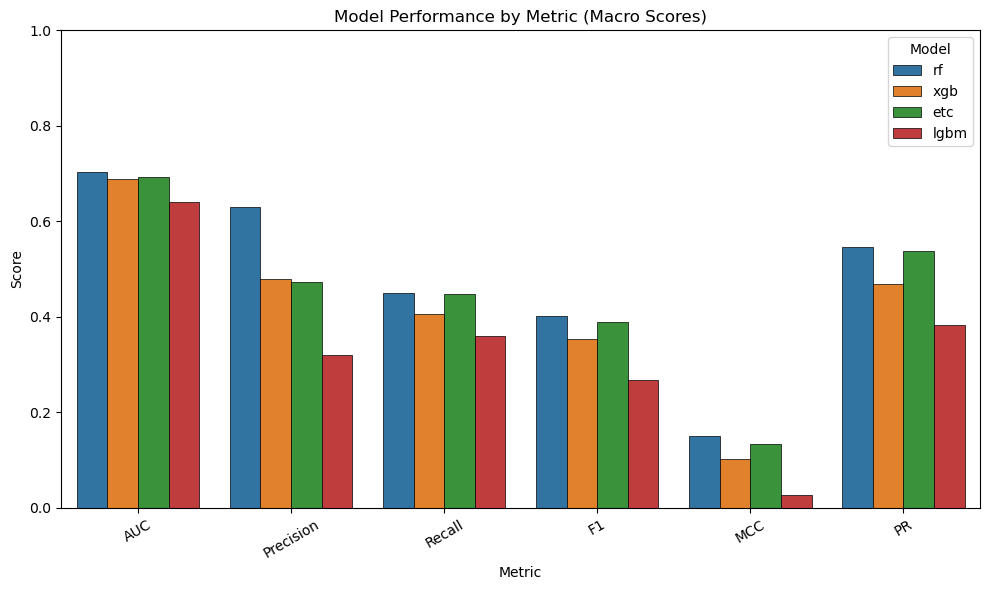

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results
df = pd.read_csv("HP_analysis_10_2025/benchmark/results/diff_models_on_combined(no grid).csv")

# Use only Macro scores to compare models
metrics = ['AUC', 'Precision', 'Recall', 'F1', 'MCC', 'PR']
df_macro = df[df['Class'] == 'Macro']

# Melt the dataframe for easier plotting
df_melt = df_macro.melt(id_vars=['Model'], value_vars=metrics, var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x='Metric', y='Score', hue='Model', ci=None, edgecolor='black', linewidth=0.5)
plt.title("Model Performance by Metric (Macro Scores)")
plt.ylabel("Score")
plt.ylim(0, 1)  
plt.xticks(rotation=30)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# 2 out of n Dataset combinations

In [8]:
import itertools
import pandas as pd

# Exclude the already combined dataset at the end
num_datasets = len(tss_datasets) - 1

all_combinations = []  # Stores the actual dataframes for each combination
all_combination_names = []  # Stores the names of datasets in each combination

# Generate all 2-dataset combinations
for combo_indices in itertools.combinations(range(num_datasets), 2):
    combination_df = pd.concat([tss_datasets[i] for i in combo_indices], axis=1)
    all_combinations.append(combination_df) # Store the dataframe separately

     # Store the names of the datasets in this combination
    all_combination_names.append([dataset_names[i] for i in combo_indices]) 
print("total combinations : ", len(all_combination_names))
print(all_combination_names)

total combinations :  21
[['SCFA', 'Metabolites'], ['SCFA', 'GCMS'], ['SCFA', 'Lipids'], ['SCFA', '16S'], ['SCFA', 'Virulence-Genes'], ['SCFA', 'RNA'], ['Metabolites', 'GCMS'], ['Metabolites', 'Lipids'], ['Metabolites', '16S'], ['Metabolites', 'Virulence-Genes'], ['Metabolites', 'RNA'], ['GCMS', 'Lipids'], ['GCMS', '16S'], ['GCMS', 'Virulence-Genes'], ['GCMS', 'RNA'], ['Lipids', '16S'], ['Lipids', 'Virulence-Genes'], ['Lipids', 'RNA'], ['16S', 'Virulence-Genes'], ['16S', 'RNA'], ['Virulence-Genes', 'RNA']]


# Evaluating the best model from above (RF) across different dataset combinations.

In [9]:
n_seeds = 2
ks = [10]
result_path = "HP_analysis_10_2025/benchmark/results/combinations_of_2_datasets(no_grid).csv"

# Loop through all dataset combinations
for combo_df, combo_names in zip(all_combinations, all_combination_names):
    combo_label = "+".join(combo_names)  # e.g., "metabolomics+transcriptomics"
    print(f"\nRunning rf model on combination: {combo_label}")
    run_classification(combo_df, y_target, ks, n_seeds, result_path, combo_label, "rf", None, use_grid=False)


Running rf model on combination: SCFA+Metabolites
[10, 466]
2
CV for seed 0 and 10 features
Performing One vs Rest classification
Macro AUC (OvR): 0.6356
Macro Precision (OvR): 0.3713
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3406
Macro MCC (OvR): 0.0927
Macro PR AUC (OvR): 0.3791
Performing One vs One classification
Macro AUC (OvO): 0.6711
Macro Precision (OvO): 0.6087
Macro Recall (OvO): 0.3444
Macro F1 (OvO): 0.4342
Macro MCC (OvO): 0.3394
Macro PR AUC (OvO): 0.4501
{'Negative control vs Rest - Precision': 0.3063063063063063, 'Negative control vs Rest - Recall': 0.7555555555555555, 'Negative control vs Rest - F1': 0.4358974358974359, 'Negative control vs Rest - MCC': np.float64(-0.13728966731595585), 'Negative control vs Rest - PR AUC': np.float64(0.4493340661154085), 'Negative control vs Rest - AUC': np.float64(0.5770287141073658), 'Patient vs Rest - Precision': 0.5, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.4, 'Patient vs Rest - MCC': np.float64

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.6940
Macro Precision (OvR): 0.3431
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3066
Macro MCC (OvR): 0.0868
Macro PR AUC (OvR): 0.4522
Performing One vs One classification
Macro AUC (OvO): 0.7191
Macro Precision (OvO): 0.4811
Macro Recall (OvO): 0.3111
Macro F1 (OvO): 0.3757
Macro MCC (OvO): 0.3089
Macro PR AUC (OvO): 0.4890
{'Negative control vs Rest - Precision': 0.31496062992125984, 'Negative control vs Rest - Recall': 0.8888888888888888, 'Negative control vs Rest - F1': 0.46511627906976744, 'Negative control vs Rest - MCC': np.float64(-0.18813786545197195), 'Negative control vs Rest - PR AUC': np.float64(0.5163625699558035), 'Negative control vs Rest - AUC': np.float64(0.6340823970037454), 'Patient vs Rest - Precision': 0.7142857142857143, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.45454545454545453, 'Patient vs Rest - MCC': np.float64(0.44851653370375394), 'Patient vs Rest - PR AUC': np.float64(0.4904518201419965), 'Patient vs Res

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.6567
Macro Precision (OvO): 0.1333
Macro Recall (OvO): 0.0444
Macro F1 (OvO): 0.0667
Macro MCC (OvO): -0.0086
Macro PR AUC (OvO): 0.4007
{'Negative control vs Rest - Precision': 0.328, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.4823529411764706, 'Negative control vs Rest - MCC': np.float64(-0.06171543212481474), 'Negative control vs Rest - PR AUC': np.float64(0.5185260890642395), 'Negative control vs Rest - AUC': np.float64(0.6764044943820224), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.5008902675645358), 'Patient vs Rest - AUC': np.float64(0.8862745098039216), 'Positive control vs Rest - Precision': 0.125, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05263157894736842, 'Positive control vs Rest - MCC': np.float64(-0.05

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.6590
Macro Precision (OvO): 0.1667
Macro Recall (OvO): 0.0222
Macro F1 (OvO): 0.0392
Macro MCC (OvO): -0.0381
Macro PR AUC (OvO): 0.4044
{'Negative control vs Rest - Precision': 0.3178294573643411, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47126436781609193, 'Negative control vs Rest - MCC': np.float64(-0.19349924352143671), 'Negative control vs Rest - PR AUC': np.float64(0.5809432432301296), 'Negative control vs Rest - AUC': np.float64(0.6529338327091136), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.35348029765911765), 'Patient vs Rest - AUC': np.float64(0.784593837535014), 'Positive control vs Rest - Precision': 0.25, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.058823529411764705, 'Positive control vs Rest - MCC': np

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.6985
Macro Precision (OvR): 0.2361
Macro Recall (OvR): 0.3778
Macro F1 (OvR): 0.2507
Macro MCC (OvR): 0.0631
Macro PR AUC (OvR): 0.4403
Performing One vs One classification
Macro AUC (OvO): 0.7649
Macro Precision (OvO): 0.7685
Macro Recall (OvO): 0.3333
Macro F1 (OvO): 0.4028
Macro MCC (OvO): 0.3729
Macro PR AUC (OvO): 0.5149
{'Negative control vs Rest - Precision': 0.3333333333333333, 'Negative control vs Rest - Recall': 0.9333333333333333, 'Negative control vs Rest - F1': 0.49122807017543857, 'Negative control vs Rest - MCC': np.float64(-0.02090344009344693), 'Negative control vs Rest - PR AUC': np.float64(0.4988419294186283), 'Negative control vs Rest - AUC': np.float64(0.650187265917603), 'Patient vs Rest - Precision': 0.375, 'Patient vs Rest - Recall': 0.2, 'Patient vs Rest - F1': 0.2608695652173913, 'Patient vs Rest - MCC': np.float64(0.2102324405785859), 'Patient vs Rest - PR AUC': np.float64(0.45737121852541834), 'Patient vs Rest - AUC': np.float64(0.81848739

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.7439
Macro Precision (OvO): 0.3929
Macro Recall (OvO): 0.2000
Macro F1 (OvO): 0.2648
Macro MCC (OvO): 0.2095
Macro PR AUC (OvO): 0.4351
{'Negative control vs Rest - Precision': 0.31746031746031744, 'Negative control vs Rest - Recall': 0.8888888888888888, 'Negative control vs Rest - F1': 0.4678362573099415, 'Negative control vs Rest - MCC': np.float64(-0.1542872959278226), 'Negative control vs Rest - PR AUC': np.float64(0.45443189213722696), 'Negative control vs Rest - AUC': np.float64(0.6223470661672907), 'Patient vs Rest - Precision': 0.7142857142857143, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.45454545454545453, 'Patient vs Rest - MCC': np.float64(0.44851653370375394), 'Patient vs Rest - PR AUC': np.float64(0.3876753489127239), 'Patient vs Rest - AUC': np.float64(0.830812324929972), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest -

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.6864
Macro Precision (OvR): 0.3431
Macro Recall (OvR): 0.4074
Macro F1 (OvR): 0.3066
Macro MCC (OvR): 0.0868
Macro PR AUC (OvR): 0.4606
Performing One vs One classification
Macro AUC (OvO): 0.7344
Macro Precision (OvO): 0.5000
Macro Recall (OvO): 0.2667
Macro F1 (OvO): 0.3478
Macro MCC (OvO): 0.2920
Macro PR AUC (OvO): 0.4906
{'Negative control vs Rest - Precision': 0.31496062992125984, 'Negative control vs Rest - Recall': 0.8888888888888888, 'Negative control vs Rest - F1': 0.46511627906976744, 'Negative control vs Rest - MCC': np.float64(-0.18813786545197195), 'Negative control vs Rest - PR AUC': np.float64(0.5372792915455415), 'Negative control vs Rest - AUC': np.float64(0.6368289637952559), 'Patient vs Rest - Precision': 0.7142857142857143, 'Patient vs Rest - Recall': 0.3333333333333333, 'Patient vs Rest - F1': 0.45454545454545453, 'Patient vs Rest - MCC': np.float64(0.44851653370375394), 'Patient vs Rest - PR AUC': np.float64(0.5699247375376871), 'Patient vs Res

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.6987
Macro Precision (OvR): 0.4385
Macro Recall (OvR): 0.3926
Macro F1 (OvR): 0.2965
Macro MCC (OvR): 0.0825
Macro PR AUC (OvR): 0.4349
Performing One vs One classification
Macro AUC (OvO): 0.7331
Macro Precision (OvO): 0.6000
Macro Recall (OvO): 0.2667
Macro F1 (OvO): 0.3652
Macro MCC (OvO): 0.3412
Macro PR AUC (OvO): 0.4825
{'Negative control vs Rest - Precision': 0.3153846153846154, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.4685714285714286, 'Negative control vs Rest - MCC': np.float64(-0.24668745581139884), 'Negative control vs Rest - PR AUC': np.float64(0.5048267491441913), 'Negative control vs Rest - AUC': np.float64(0.6525593008739076), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.26666666666666666, 'Patient vs Rest - F1': 0.42105263157894735, 'Patient vs Rest - MCC': np.float64(0.49406736797987794), 'Patient vs Rest - PR AUC': np.float64(0.514045044096939), 'Patient vs Rest - AUC': np.floa

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.7373
Macro Precision (OvR): 0.4293
Macro Recall (OvR): 0.4667
Macro F1 (OvR): 0.3912
Macro MCC (OvR): 0.1261
Macro PR AUC (OvR): 0.5837
Performing One vs One classification
Macro AUC (OvO): 0.7843
Macro Precision (OvO): 0.9487
Macro Recall (OvO): 0.4778
Macro F1 (OvO): 0.5501
Macro MCC (OvO): 0.5488
Macro PR AUC (OvO): 0.6453
{'Negative control vs Rest - Precision': 0.288, 'Negative control vs Rest - Recall': 0.8, 'Negative control vs Rest - F1': 0.4235294117647059, 'Negative control vs Rest - MCC': np.float64(-0.37735924528226417), 'Negative control vs Rest - PR AUC': np.float64(0.6470647997021086), 'Negative control vs Rest - AUC': np.float64(0.6986267166042447), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.6, 'Patient vs Rest - F1': 0.75, 'Patient vs Rest - MCC': np.float64(0.7557777451076474), 'Patient vs Rest - PR AUC': np.float64(0.7646953248357988), 'Patient vs Rest - AUC': np.float64(0.8400560224089636), 'Positive control vs Rest - Precis

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.7360
Macro Precision (OvR): 0.3968
Macro Recall (OvR): 0.4667
Macro F1 (OvR): 0.3820
Macro MCC (OvR): 0.1235
Macro PR AUC (OvR): 0.5688
Performing One vs One classification
Macro AUC (OvO): 0.7731
Macro Precision (OvO): 0.7475
Macro Recall (OvO): 0.4333
Macro F1 (OvO): 0.5266
Macro MCC (OvO): 0.4953
Macro PR AUC (OvO): 0.6192
{'Negative control vs Rest - Precision': 0.2903225806451613, 'Negative control vs Rest - Recall': 0.8, 'Negative control vs Rest - F1': 0.4260355029585799, 'Negative control vs Rest - MCC': np.float64(-0.33924206075946584), 'Negative control vs Rest - PR AUC': np.float64(0.6269085672031474), 'Negative control vs Rest - AUC': np.float64(0.6911360799001249), 'Patient vs Rest - Precision': 0.9, 'Patient vs Rest - Recall': 0.6, 'Patient vs Rest - F1': 0.72, 'Patient vs Rest - MCC': np.float64(0.7097966828493963), 'Patient vs Rest - PR AUC': np.float64(0.7523444034018155), 'Patient vs Rest - AUC': np.float64(0.8747899159663867), 'Positive control vs 

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.7241
Macro Precision (OvO): 0.2667
Macro Recall (OvO): 0.0889
Macro F1 (OvO): 0.1333
Macro MCC (OvO): 0.0806
Macro PR AUC (OvO): 0.5081
{'Negative control vs Rest - Precision': 0.3203125, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47398843930635837, 'Negative control vs Rest - MCC': np.float64(-0.15167002781255928), 'Negative control vs Rest - PR AUC': np.float64(0.569862008229523), 'Negative control vs Rest - AUC': np.float64(0.6504369538077404), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.4942652283656482), 'Patient vs Rest - AUC': np.float64(0.8717086834733894), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.10573873360945339), 'Positive con

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.7577
Macro Precision (OvO): 0.5278
Macro Recall (OvO): 0.3111
Macro F1 (OvO): 0.3810
Macro MCC (OvO): 0.3394
Macro PR AUC (OvO): 0.5340
{'Negative control vs Rest - Precision': 0.29508196721311475, 'Negative control vs Rest - Recall': 0.8, 'Negative control vs Rest - F1': 0.4311377245508982, 'Negative control vs Rest - MCC': np.float64(-0.27504416162765494), 'Negative control vs Rest - PR AUC': np.float64(0.5898840367716176), 'Negative control vs Rest - AUC': np.float64(0.6910112359550561), 'Patient vs Rest - Precision': 0.6, 'Patient vs Rest - Recall': 0.4, 'Patient vs Rest - F1': 0.48, 'Patient vs Rest - MCC': np.float64(0.4395899910828648), 'Patient vs Rest - PR AUC': np.float64(0.5440263166761451), 'Patient vs Rest - AUC': np.float64(0.8229691876750701), 'Positive control vs Rest - Precision': 0.5, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.0625, 'Positive control vs Rest - MCC': np.float64(0.08153657399114153), '

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.8324
Macro Precision (OvO): 0.6389
Macro Recall (OvO): 0.4667
Macro F1 (OvO): 0.5383
Macro MCC (OvO): 0.5136
Macro PR AUC (OvO): 0.6389
{'Negative control vs Rest - Precision': 0.2845528455284553, 'Negative control vs Rest - Recall': 0.7777777777777778, 'Negative control vs Rest - F1': 0.4166666666666667, 'Negative control vs Rest - MCC': np.float64(-0.36299993765033994), 'Negative control vs Rest - PR AUC': np.float64(0.6099704583078842), 'Negative control vs Rest - AUC': np.float64(0.7041198501872659), 'Patient vs Rest - Precision': 1.0, 'Patient vs Rest - Recall': 0.6666666666666666, 'Patient vs Rest - F1': 0.8, 'Patient vs Rest - MCC': np.float64(0.7998655801049069), 'Patient vs Rest - PR AUC': np.float64(0.8326355605704971), 'Patient vs Rest - AUC': np.float64(0.9372549019607843), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.04657127599

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.7009
Macro Precision (OvO): 0.2500
Macro Recall (OvO): 0.0556
Macro F1 (OvO): 0.0898
Macro MCC (OvO): 0.0365
Macro PR AUC (OvO): 0.4182
{'Negative control vs Rest - Precision': 0.3253968253968254, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47953216374269003, 'Negative control vs Rest - MCC': np.float64(-0.08759536801063475), 'Negative control vs Rest - PR AUC': np.float64(0.4998296832860145), 'Negative control vs Rest - AUC': np.float64(0.6157303370786518), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.4337081399510245), 'Patient vs Rest - AUC': np.float64(0.8473389355742298), 'Positive control vs Rest - Precision': 0.14285714285714285, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05405405405405406, 'Positive control vs Re

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.6644
Macro Precision (OvO): 0.3056
Macro Recall (OvO): 0.0444
Macro F1 (OvO): 0.0755
Macro MCC (OvO): 0.0328
Macro PR AUC (OvO): 0.3898
{'Negative control vs Rest - Precision': 0.32558139534883723, 'Negative control vs Rest - Recall': 0.9333333333333333, 'Negative control vs Rest - F1': 0.4827586206896552, 'Negative control vs Rest - MCC': np.float64(-0.11012657911027106), 'Negative control vs Rest - PR AUC': np.float64(0.5095727118793851), 'Negative control vs Rest - AUC': np.float64(0.6369538077403245), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.3027557366809851), 'Patient vs Rest - AUC': np.float64(0.8221288515406162), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.09421114395319916), 'Po

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.7325
Macro Precision (OvO): 0.0000
Macro Recall (OvO): 0.0000
Macro F1 (OvO): 0.0000
Macro MCC (OvO): -0.0686
Macro PR AUC (OvO): 0.4619
{'Negative control vs Rest - Precision': 0.3228346456692913, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47674418604651164, 'Negative control vs Rest - MCC': np.float64(-0.11712244581657971), 'Negative control vs Rest - PR AUC': np.float64(0.5661268105841849), 'Negative control vs Rest - AUC': np.float64(0.6428214731585519), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': np.float64(-0.03078550828004397), 'Patient vs Rest - PR AUC': np.float64(0.6042914076374452), 'Patient vs Rest - AUC': np.float64(0.8806722689075631), 'Positive control vs Rest - Precision': 0.16666666666666666, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05555555555555555, 'Positive control vs R

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.7149
Macro Precision (OvR): 0.1623
Macro Recall (OvR): 0.3148
Macro F1 (OvR): 0.1765
Macro MCC (OvR): -0.0605
Macro PR AUC (OvR): 0.3988
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.7363
Macro Precision (OvO): 0.2778
Macro Recall (OvO): 0.0333
Macro F1 (OvO): 0.0579
Macro MCC (OvO): 0.0249
Macro PR AUC (OvO): 0.4581
{'Negative control vs Rest - Precision': 0.3203125, 'Negative control vs Rest - Recall': 0.9111111111111111, 'Negative control vs Rest - F1': 0.47398843930635837, 'Negative control vs Rest - MCC': np.float64(-0.15167002781255928), 'Negative control vs Rest - PR AUC': np.float64(0.5875740716252477), 'Negative control vs Rest - AUC': np.float64(0.7136079900124844), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.3611291532277143), 'Patient vs Rest - AUC': np.float64(0.8529411764705883), 'Positive control vs Rest - Precision': 0.16666666666666666, 'Positive control vs Rest - Recall': 0.03333333333333333, 'Positive control vs Rest - F1': 0.05555555555555555, 'Positive control vs Rest - MCC': np.float64(-0.0297166551619

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.5042
Macro Precision (OvR): 0.1128
Macro Recall (OvR): 0.3333
Macro F1 (OvR): 0.1685
Macro MCC (OvR): 0.0050
Macro PR AUC (OvR): 0.2125
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.7006
Macro Precision (OvO): 0.2083
Macro Recall (OvO): 0.1111
Macro F1 (OvO): 0.1449
Macro MCC (OvO): 0.0706
Macro PR AUC (OvO): 0.2914
{'Negative control vs Rest - Precision': 0.3383458646616541, 'Negative control vs Rest - Recall': 1.0, 'Negative control vs Rest - F1': 0.5056179775280899, 'Negative control vs Rest - MCC': np.float64(0.06165743206445295), 'Negative control vs Rest - PR AUC': np.float64(0.31443683911995846), 'Negative control vs Rest - AUC': np.float64(0.48039950062421977), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.10836478423595622), 'Patient vs Rest - AUC': np.float64(0.511484593837535), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.04657127599530762), 'Positive control vs Rest - PR AUC': np.float64

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.5497
Macro Precision (OvR): 0.1670
Macro Recall (OvR): 0.3333
Macro F1 (OvR): 0.1997
Macro MCC (OvR): 0.0059
Macro PR AUC (OvR): 0.2315
Performing One vs One classification
Macro AUC (OvO): 0.5622
Macro Precision (OvO): 0.3491
Macro Recall (OvO): 0.1778
Macro F1 (OvO): 0.2313
Macro MCC (OvO): 0.0910
Macro PR AUC (OvO): 0.2729
{'Negative control vs Rest - Precision': 0.34710743801652894, 'Negative control vs Rest - Recall': 0.9333333333333333, 'Negative control vs Rest - F1': 0.5060240963855421, 'Negative control vs Rest - MCC': np.float64(0.07290972634922238), 'Negative control vs Rest - PR AUC': np.float64(0.34181975857486707), 'Negative control vs Rest - AUC': np.float64(0.5448189762796504), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.12999240917949134), 'Patient vs Rest - AUC': np.float64(0.5971988795518207), 'Positive control vs Rest - Prec

/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvR): 0.5486
Macro Precision (OvR): 0.1128
Macro Recall (OvR): 0.3333
Macro F1 (OvR): 0.1685
Macro MCC (OvR): 0.0050
Macro PR AUC (OvR): 0.2456
Performing One vs One classification


/home/renu/miniconda3/envs/planemo-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro AUC (OvO): 0.5539
Macro Precision (OvO): 0.2222
Macro Recall (OvO): 0.0889
Macro F1 (OvO): 0.1270
Macro MCC (OvO): 0.0746
Macro PR AUC (OvO): 0.2743
{'Negative control vs Rest - Precision': 0.3383458646616541, 'Negative control vs Rest - Recall': 1.0, 'Negative control vs Rest - F1': 0.5056179775280899, 'Negative control vs Rest - MCC': np.float64(0.06165743206445295), 'Negative control vs Rest - PR AUC': np.float64(0.3372016330018098), 'Negative control vs Rest - AUC': np.float64(0.4957553058676654), 'Patient vs Rest - Precision': 0.0, 'Patient vs Rest - Recall': 0.0, 'Patient vs Rest - F1': 0.0, 'Patient vs Rest - MCC': 0.0, 'Patient vs Rest - PR AUC': np.float64(0.18069036875509714), 'Patient vs Rest - AUC': np.float64(0.6487394957983194), 'Positive control vs Rest - Precision': 0.0, 'Positive control vs Rest - Recall': 0.0, 'Positive control vs Rest - F1': 0.0, 'Positive control vs Rest - MCC': np.float64(-0.04657127599530762), 'Positive control vs Rest - PR AUC': np.float64(

# Plot Macro Scores Across 2-Dataset Combinations

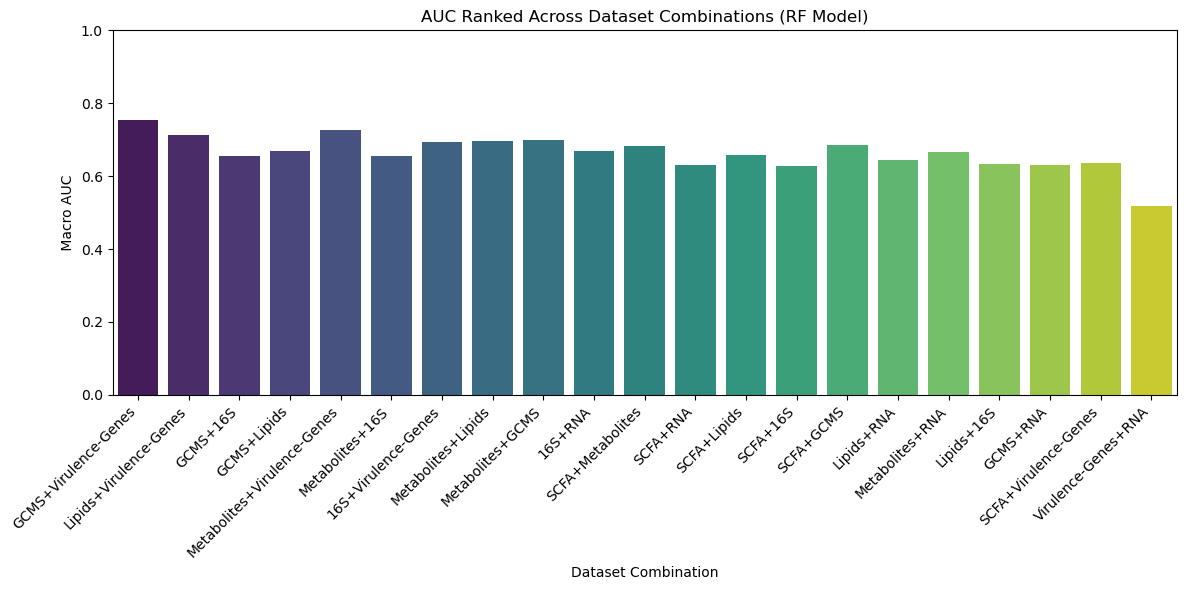

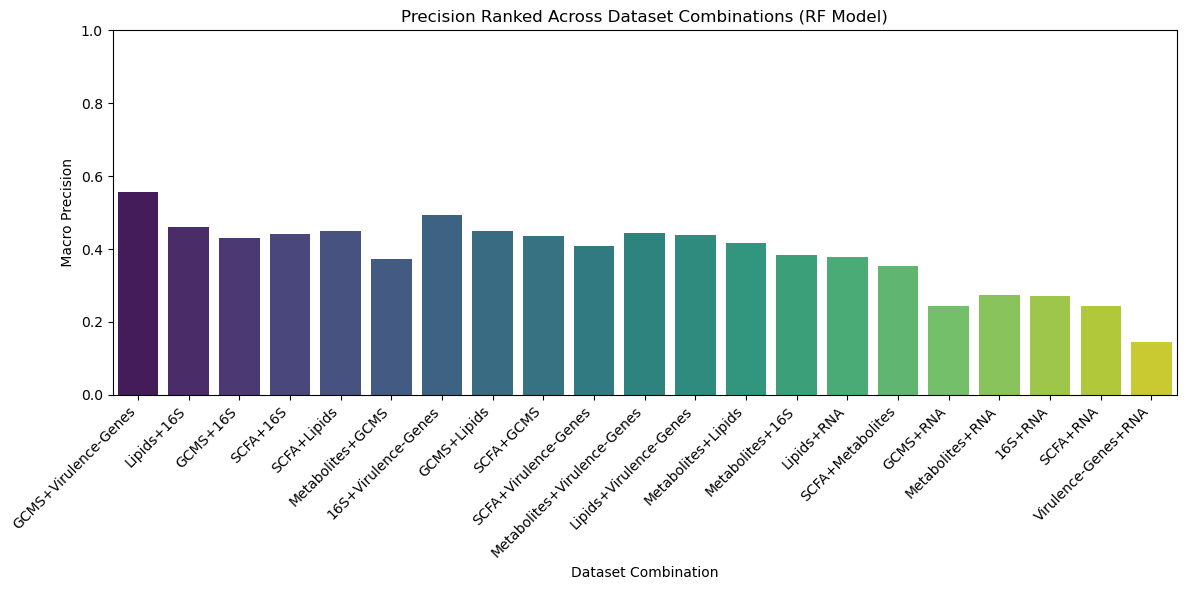

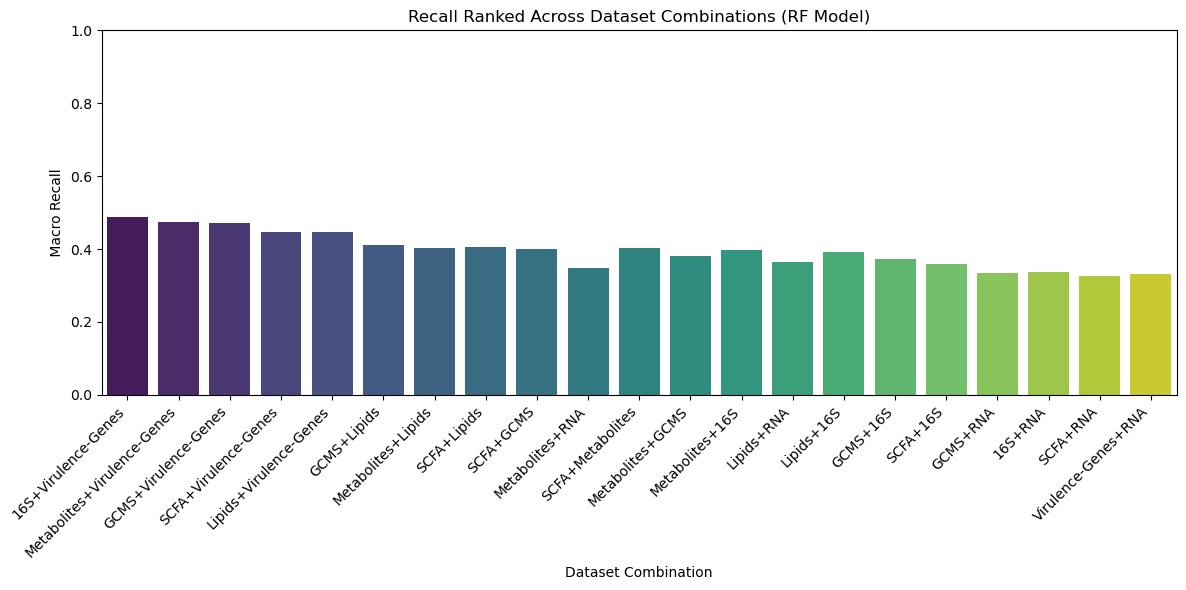

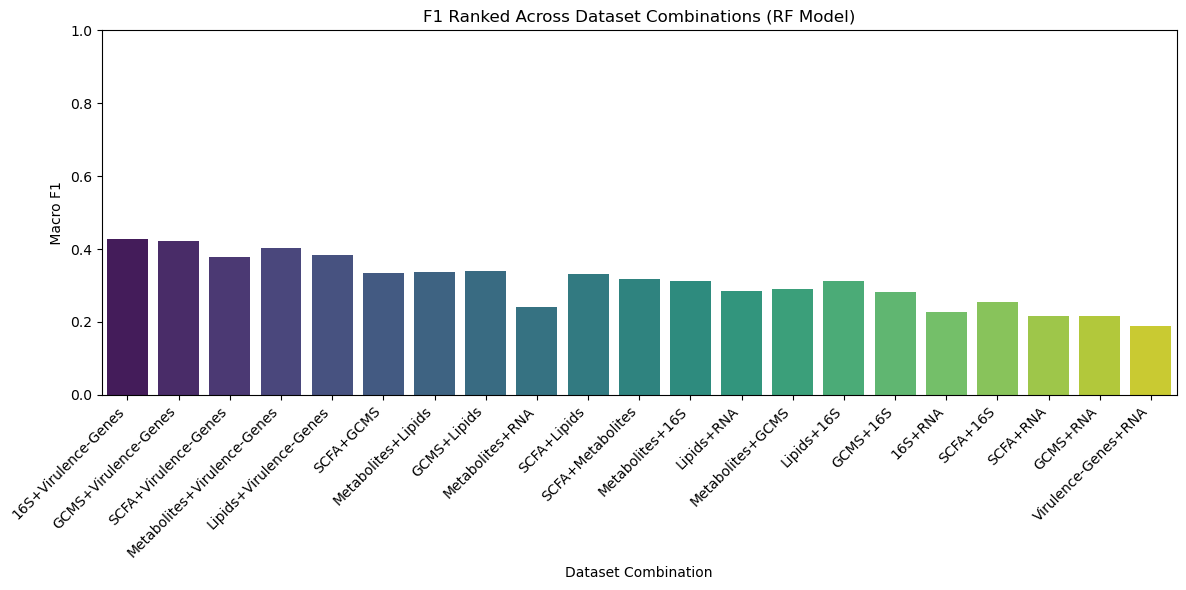

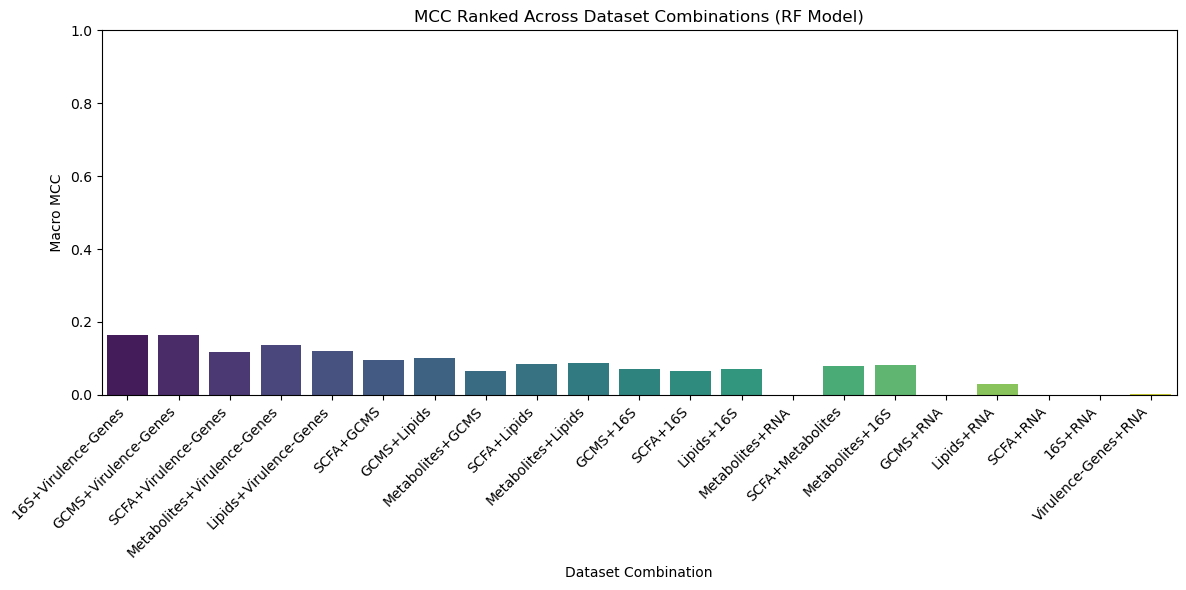

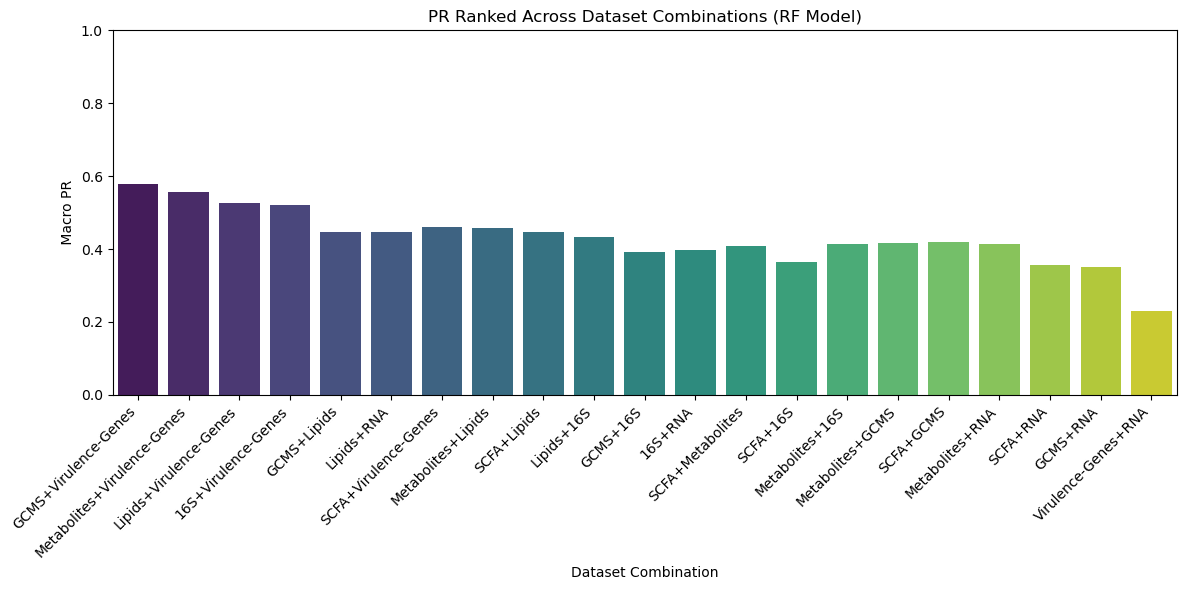

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results
df = pd.read_csv("HP_analysis_10_2025/benchmark/results/combinations_of_2_datasets(no_grid).csv")

# Keep only Macro class scores
df_macro = df[df['Class'] == 'Macro']

# List of metrics to plot (adjust based on your CSV)
metrics = ['AUC', 'Precision', 'Recall', 'F1', 'MCC', 'PR']

#  Ranked Barplots per metric ---
for metric in metrics:
    plt.figure(figsize=(12,6))
    df_sorted = df_macro.sort_values(metric, ascending=False)
    sns.barplot(data=df_sorted, x='Label', y=metric, palette='viridis', ci=None)
    plt.title(f"{metric} Ranked Across Dataset Combinations (RF Model)")
    plt.ylabel(f" Macro {metric} ")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Dataset Combination")
    plt.tight_layout()
    plt.show()

    
   

# Plot all Metric scores for top 5 dataset combinations 

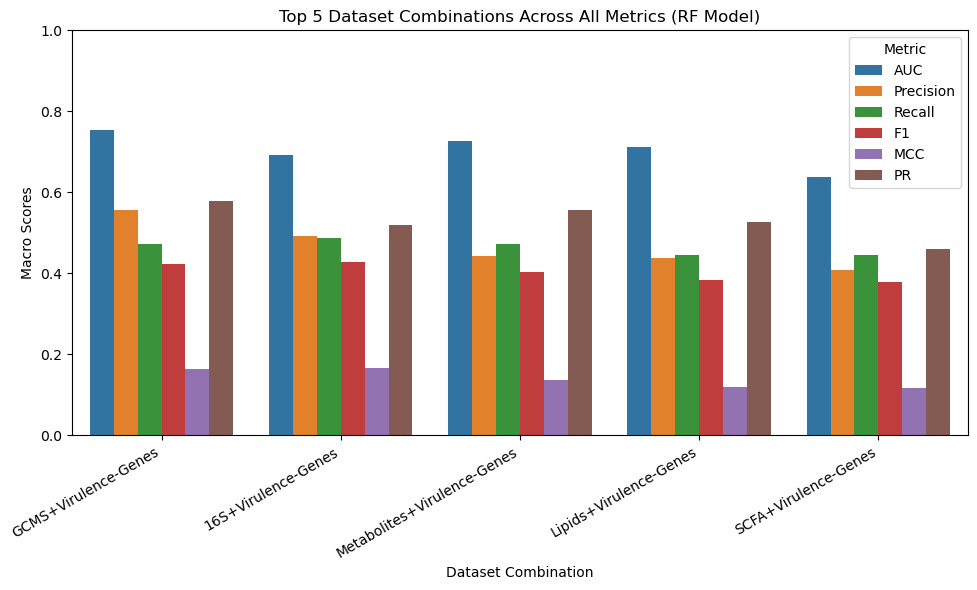

In [32]:
# Load the results
df = pd.read_csv("HP_analysis_10_2025/benchmark/results/combinations_of_2_datasets(no_grid).csv")

# Keep only Macro scores
df_macro = df[df['Class'] == 'Macro']

# List of metrics
metrics = ['AUC', 'Precision', 'Recall', 'F1', 'MCC', 'PR']

# Compute overall mean per label
label_means = df_macro.groupby('Label')[metrics].mean().reset_index()

# Select top 5 dataset combinations
label_means['Overall'] = label_means[metrics].mean(axis=1)
top5_df = label_means.sort_values('Overall', ascending=False).head(5)


# Melt the dataframe for seaborn plotting
df_long = top5_df.melt(id_vars='Label', value_vars=metrics, var_name='Metric', value_name='Score')


# Plot grouped barplot for top 5 combinations
plt.figure(figsize=(10,6))
sns.barplot(data=df_long, x='Label', y='Score', hue='Metric', ci=None)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.title("Top 5 Dataset Combinations Across All Metrics (RF Model)")
plt.xlabel("Dataset Combination")
plt.ylabel("Macro Scores")
plt.legend(title='Metric')
plt.tight_layout()
plt.show()



   